# Первое задание по вычислительной математике. Жесткие системы ОДУ и их решения

In [7]:
# Подключаем заклинания
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sympy import diff, symbols, Symbol, integrate, solve, sqrt, log, sin, cos, lambdify
from scipy.integrate import solve_ivp
from scipy import sqrt
from spellbook import *
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()

Вводим систему и начальные условия из задания

In [3]:
def f(t, y):
    return np.array([
        -1.71*y[0] + 0.43*y[1] + 8.23*y[2] + 0.0007,
        1.71*y[0] - 8.75*y[1],
        -10.03*y[2] + 0.43*y[3] + 0.035*y[4],
        8.32*y[1] + 1.71*y[2] - 1.12*y[3],
        -1.745*y[4] + 0.43*y[5] + 0.43*y[6],
        -280*y[5]*y[7] + 0.69*y[3] + 1.71*y[4] - 0.43*y[5] + 0.69*y[6],
        280*y[5]*y[7] - 1.87*y[6],
        -280*y[5]*y[7] + 1.87*y[6]
    ])

t0, te = 0, 421.8122
init = array([1, 0, 0, 0, 0, 0, 0, 0.0057])
n_steps = 40000

## Часть 0. Эталонное решение
В качестве образца использован метод Гаусса, который имеет 6-й порядок аппроксимации. Подробнее о методе можно прочитать на странице 47 в книге:
Iserles, Arieh (1996), A First Course in the Numerical Analysis of Differential Equations, Cambridge University Press, ISBN 978-0-521-55655-2

In [4]:
gauss = Gauss(f, init, t0, te, n_steps)

In [5]:
gauss.solve()

100%|██████████| 40001/40001 [05:20<00:00, 125.00it/s]


Визуализируем зависимость всех переменных от времени

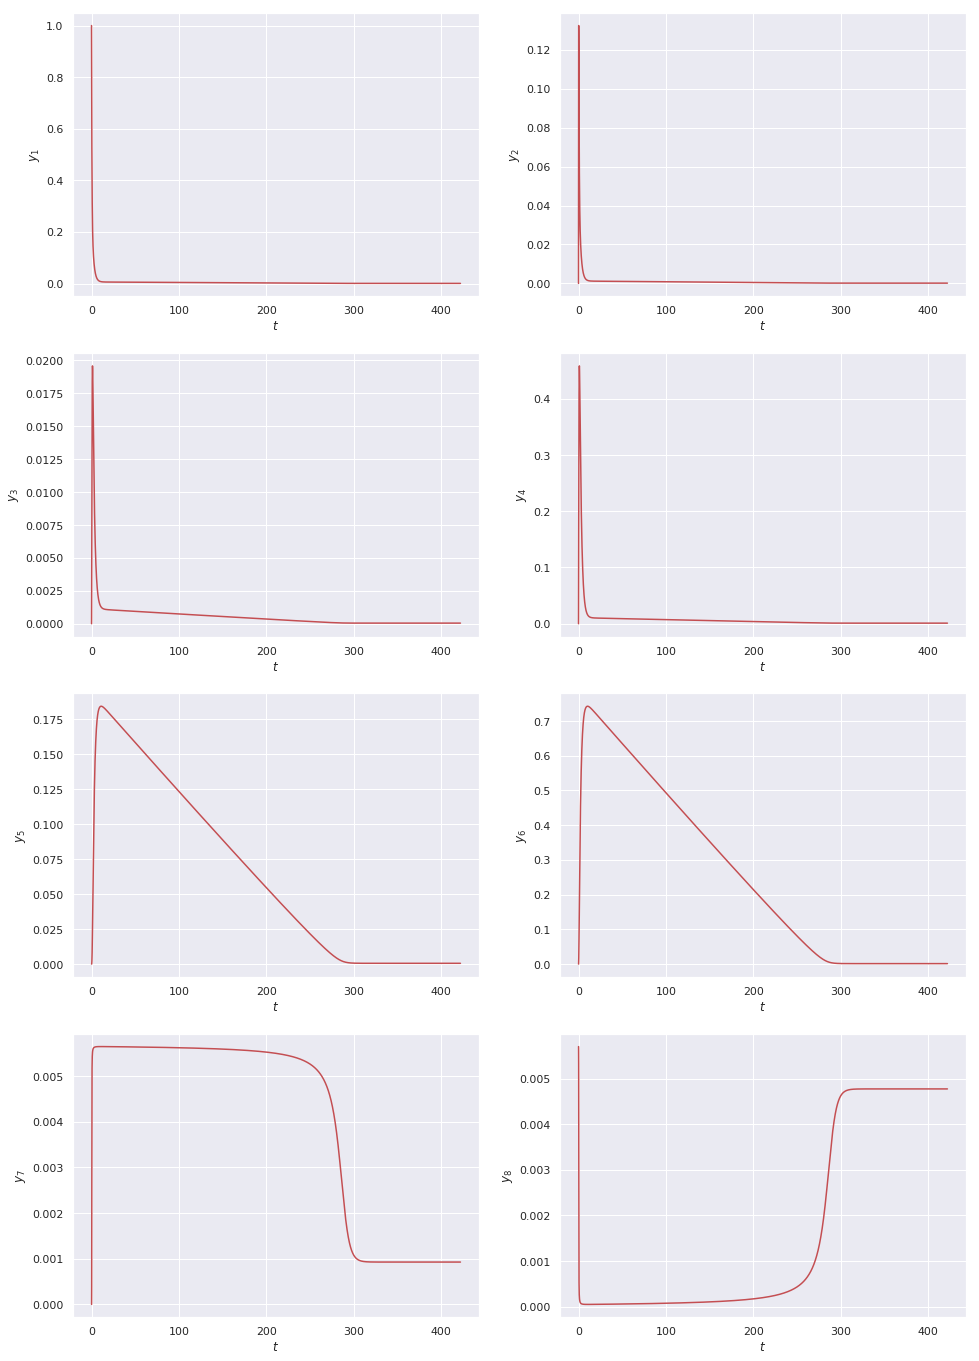

In [37]:
paragon = np.array(gauss.solution)
fig, axes = plt.subplots(4,2, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(paragon[:, 0], paragon[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()

## Часть 1. Неявные методы Рунге-Кутты

Имплементируем методы из задания

In [7]:
s = sqrt(2)
A = array([[0.5*(2+s), 0],
           [-s, 0.5*(2+s) ]])
b = array([0.5, 0.5])
c = array([0.5*(2+s), 0.5*(2-s)])

sdirk1 = RungeImplicit(A, b, c, f, init, t0, te, n_steps)

A = array([[0.5*(2-s), 0],
           [s, 0.5*(2-s) ]])
b = array([0.5, 0.5])
c = array([0.5*(2-s), 0.5*(2+s)])

sdirk2 = RungeImplicit(A, b, c, f, init, t0, te, n_steps)

q = sqrt(3)
A = array([[(1/6)*(3+q), 0],
           [(1/6)*(3-2*q), (1/6)*(3+q)]])
b = array([0.5, 0.5])
c = array([(1/6)*(3+q), (1/6)*(3-q)])

sdirk3 = RungeImplicit(A, b, c, f, init, t0, te, n_steps)

И получим решения системы

In [8]:
sdirk1.solve()

100%|██████████| 40001/40001 [04:58<00:00, 134.12it/s]


In [9]:
sdirk2.solve()

100%|██████████| 40001/40001 [04:55<00:00, 135.36it/s]


In [10]:
sdirk3.solve()

100%|██████████| 40001/40001 [04:56<00:00, 135.02it/s]


## Часть 2. Формулы дифференцирования назад
Выполним все действия предыдущего пункта для формул дифференцирования назад и получим также решение при помощи метода в представлении Нордсика.

In [12]:
bdf_sol = bdf2(f, init, t0, te, n_steps)
bdf_sol = np.vstack((bdf_sol.t, bdf_sol.y)).T
bdf_sol_nord = bdf2_nord(f, init, t0, te, n_steps)
bdf_sol_nord = np.vstack((bdf_sol_nord.t, bdf_sol_nord.y)).T

## Часть 3. Метод CROS

In [13]:
cros = CROS(f, init, t0, te, n_steps)

In [14]:
cros.solve()

100%|██████████| 40001/40001 [02:33<00:00, 260.97it/s]


## Часть 4. Сравнение результатов

Для сравнения результатов с эталоном рассчитаем абсолютную ошибку по переменным $y_3$, $y_5$, $y_8$ и визуализируем её

In [15]:
solutions  = {'SDIRK1': array(sdirk1.solution),
              'SDIRK2':array(sdirk2.solution),
              'SDIRK3':array(sdirk3.solution),
              'BDF':bdf_sol,
              'CROS':array(cros.solution),
              'BDF_Nordsieck':bdf_sol_nord}

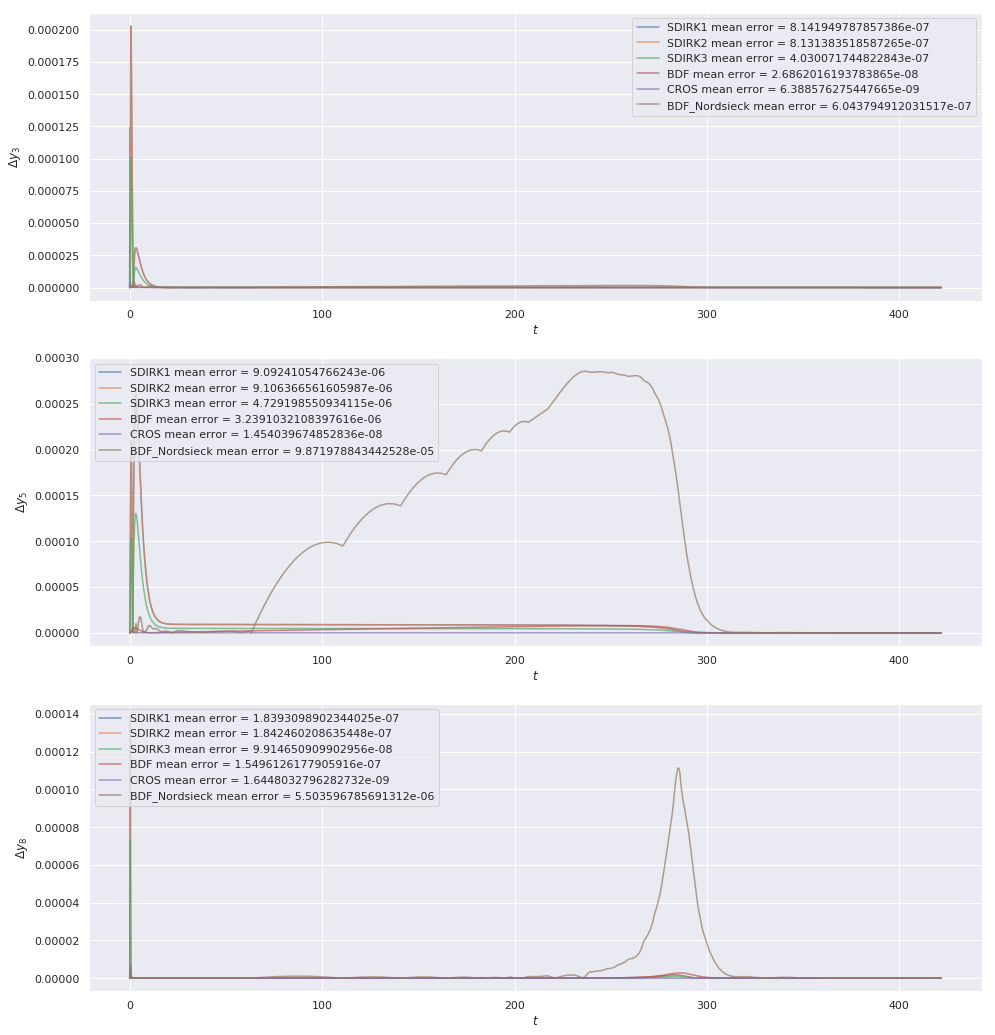

In [16]:
fig, axes = plt.subplots(3,1, figsize=(16, 18))
var = [3, 5, 8]
for i, ax in enumerate(axes.flatten()):
    for model in solutions:
        differ = np.abs(solutions[model][:, var[i]][:n_steps] - paragon[:, var[i]][:n_steps])
        ax.plot(paragon[:, 0][:n_steps], differ[:n_steps], label=model+' mean error = {}'.format(differ.mean()), alpha=0.7)
    ax.legend()
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$\Delta y_{'+str(var[i])+'}$')
plt.show()

Особый интерес представляет поведение ошибки в самом начале процесса, поэтому также визуализируем ошибку на промежутке [0, 15]

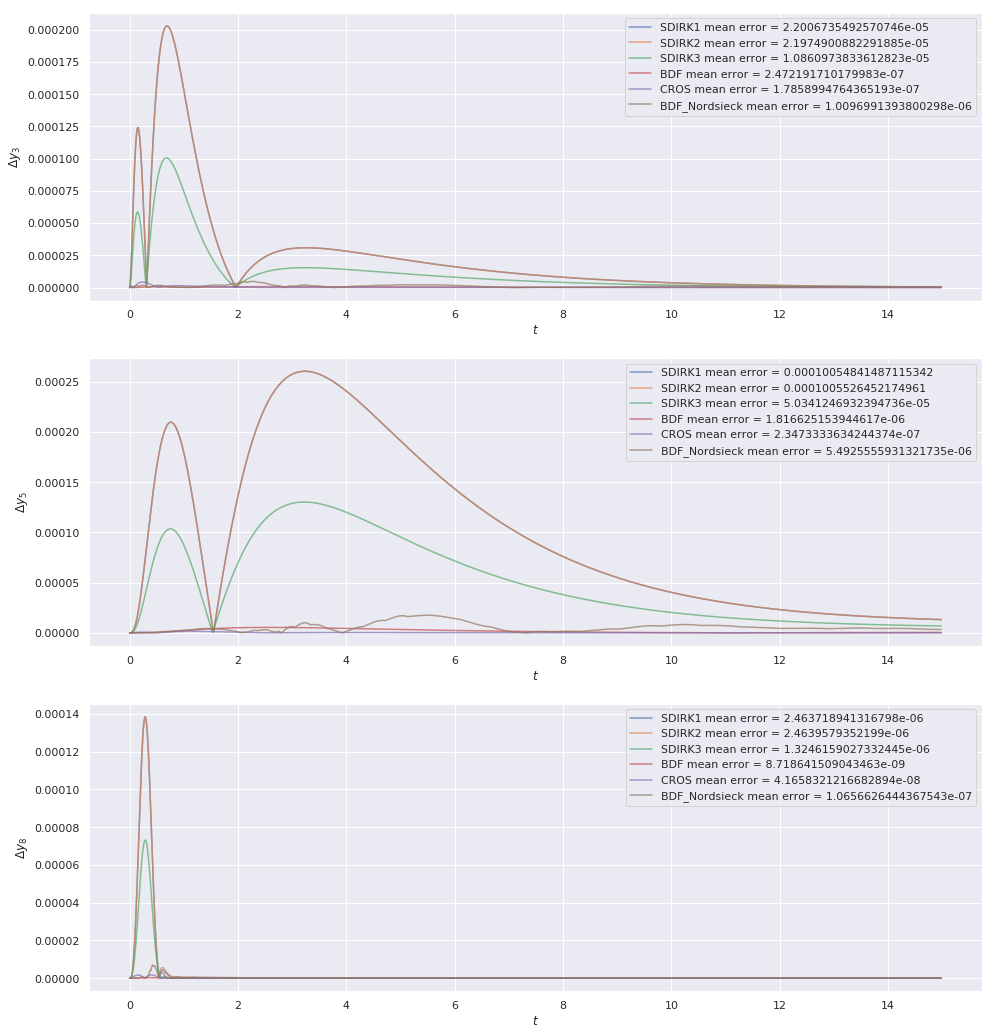

In [18]:
fig, axes = plt.subplots(3,1, figsize=(16, 18))
var = [3, 5, 8]
for i, ax in enumerate(axes.flatten()):
    for model in solutions:
        differ = np.abs(solutions[model][:, var[i]][:int((15/te)*n_steps)] - paragon[:, var[i]][:int((15/te)*n_steps)])
        ax.plot(paragon[:, 0][:int((15/te)*n_steps)], differ[:int((15/te)*n_steps)], label=model+' mean error = {}'.format(differ.mean()), alpha=0.7)
    ax.legend()
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$\Delta y_{'+str(var[i])+'}$')
plt.show()

Визуально сравним графики решений эталонного метода с самым плохим решением по переменной $y_3$ 

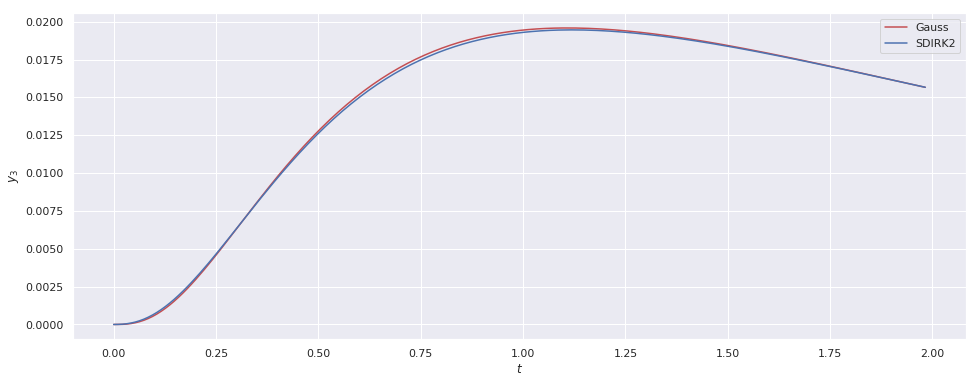

In [34]:
fig, axes = plt.subplots(figsize=(16, 6))
axes.plot(paragon[:, 0][:int((2/te)*n_steps)], paragon[:, 3][:int((2/te)*n_steps)], 'r-', label='Gauss')
axes.plot(solutions['SDIRK2'][:, 0][:int((2/te)*n_steps)], solutions['SDIRK2'][:, 3][:int((2/te)*n_steps)], 'b-', label='SDIRK2')
axes.set_xlabel('$t$')
axes.set_ylabel(r'$y_{3}$')
axes.legend()
plt.show()

Таким образом, среди исследованных методов наиболее высокое качество показал CROS. Составим общий рейтинг методов:
1. CROS
2. BDF
3. SDIRK3
4. BDF_Nordsieck
5. SDIRK1
6. SDIRK2

Как и ожидалось, использование метода BDF в представлении Нордсика ухудшило качество метода (снизился порядок аппроксимации, что сказалось на средней ошибке). При этом, расширилась область устойчивости, последствий чего на примере данной задачи наблюдать не удалось, но в перспективе может оказаться весьма полезным.

## Часть 5. Функции устойчивости использованных методов

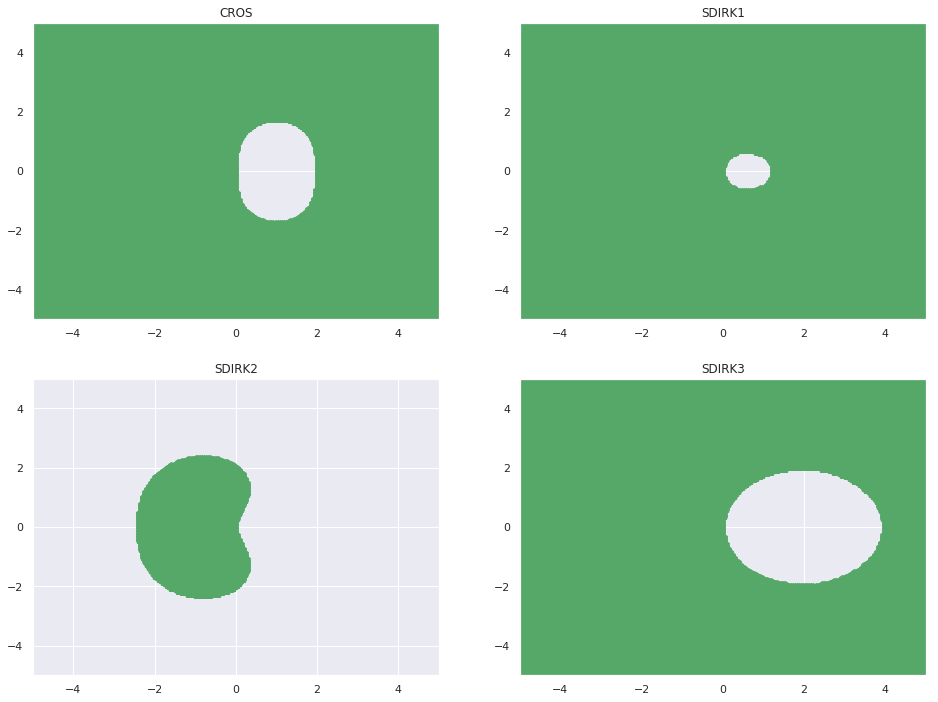

In [158]:
def plot_stability_area(ax, f, xlim, ylim):
    X = np.linspace(*xlim, 200)
    Y = np.linspace(*ylim, 200)
    X_p = []
    Y_p = []
    for x in X:
        for y in Y:
            if abs(f(complex(x, y))) <= 1:
                X_p.append(x)
                Y_p.append(y)
    ax.plot(X_p, Y_p, 'gp',  alpha=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

stability_functions = {
    'CROS': lambda z: 1/(1-z+(z*z)/2),
    'SDIRK1': lambda z: 0.5*z*(-1.4142135623731*z/(-1.70710678118655*z + 1) + 1.0)/(-1.70710678118655*z + 1) + 0.5*z/(-1.70710678118655*z + 1) + 1,
    'SDIRK2': lambda z: 0.5*z*(1.4142135623731*z/(-0.292893218813452*z + 1) + 1.0)/(-0.292893218813452*z + 1) + 0.5*z/(-0.292893218813452*z + 1) + 1,
    'SDIRK3': lambda z: 0.5*z*(-0.0773502691896257*z/(-0.788675134594813*z + 1) + 1.0)/(-0.788675134594813*z + 1) + 0.5*z/(-0.788675134594813*z + 1) + 1
}

fig, axes = plt.subplots(2, 2, figsize = (16, 12))
axes = axes.flatten()
for i, stab in enumerate(stability_functions):
    plot_stability_area(axes[i], stability_functions[stab], [-5, 5], [-5, 5])
    axes[i].set_title(stab)

Область устойивости метода BDF


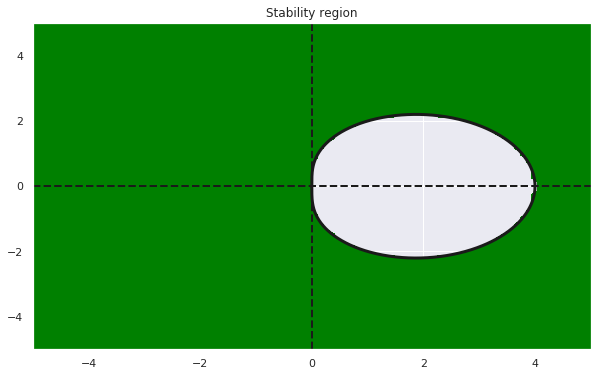

In [155]:
import nodepy.linear_multistep_method as lm
bdf2=lm.backward_difference_formula(2)
fig = bdf2.plot_stability_region(N=100, color='green', bounds=[-5, 5, -5, 5])
fig.set_size_inches((10, 6))
print('Область устойивости метода BDF')
plt.show()

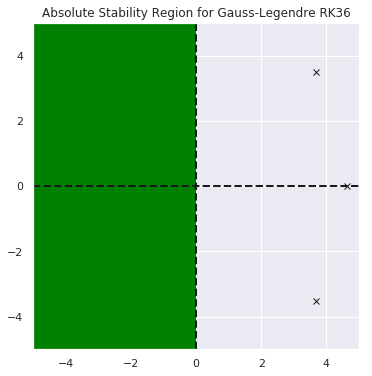

In [12]:
from nodepy import runge_kutta_method as rk
gauss = rk.loadRKM('GL3')
fig = gauss.plot_stability_region(N=100, color='green', bounds=[-5, 5, -5, 5])
fig.set_size_inches((10, 6))
plt.show()

Среди используемых методов CROS, SDIRK1, SDIRK3 и BDF оказались А-устойчивыми. Метод CROS также является L-устойчивым. В данной задаче размер области устойчивочти слабо соотносится с предпочтительностью методов. Принципиальными являются A- (то есть вхождение в состав области левой полуплоскости) и L-устойчивости, а также порядок аппроксимации методов.